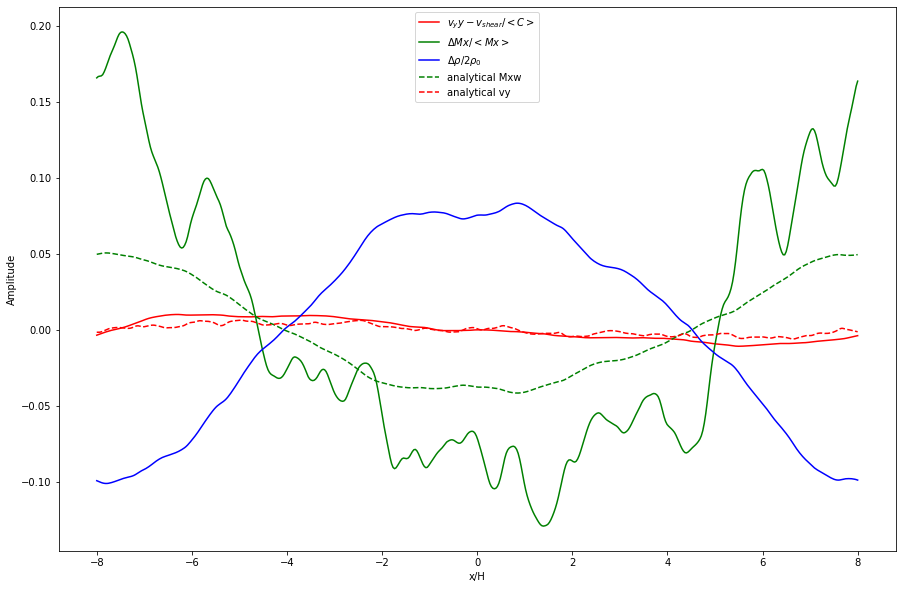

In [7]:
import sys
import time
sys.path.append('~/athena-public-version/vis/python/')
#sys.path.append('~/.local/lib/python3.8/site-packages/')
sys.path.append('~/working')


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#IMPORT APPROPRIATE ATHINPUT FILE
#import athinput.hgb as athin
import athena_read

#rho-1
def del_rho(file_name):
    #return in order the two y components of b cross v 
    data = []
    data = athena_read.athdf(file_name)
    #print(data)
    #for 8x8x1 scale height box, with cubic cells, needs to be adjusted for other sizes
    side_length = 1/len(data['x3v'])
    #print(side_length,' side length')
    volume = side_length**3    
    Nx = len(data['x1v'])
    Ny = len(data['x2v'])
    Nz = len(data['x3v'])   
    #assuming 64x256x256, but should work for any 
    overall_length = Nx*Ny*Nz
    rho = data['rho']
    #calculate radial avg profile
    rho_prof = np.sum(rho,axis=(0,1))/(Nz*Ny)
    rho_prof = rho_prof-1
    return rho_prof
#mxwell strs
def del_mxw(file_name):
    data=[]
    data = athena_read.athdf(file_name)
        #print(data)
    #for 8x8x1 scale height box, with cubic cells, needs to be adjusted for other sizes
    side_length = 1/len(data['x3v'])
    #print(side_length,' side length')
    volume = side_length**3    
    Nx = len(data['x1v'])
    Ny = len(data['x2v'])
    Nz = len(data['x3v'])   
    #assuming 64x256x256, but should work for any 
    overall_length = Nx*Ny*Nz
    minusBxBy = -1*data['Bcc1']*data['Bcc2']
    #calculate radial avg profile
    mxw_prof = np.sum(minusBxBy,axis=(0,1))/(Nz*Ny)
    #divide by mean value
    mxw_prof = ((mxw_prof-np.average(minusBxBy))/(np.average(minusBxBy)))
    return mxw_prof
#vy-vshear
def vy_min_vshear(file_name):
    data=[]
    data = athena_read.athdf(file_name)
    #for 8x8x1 scale height box, with cubic cells, needs to be adjusted for other sizes
    side_length = 1/len(data['x3v'])
    volume = side_length**3    
    Nx = len(data['x1v'])
    Ny = len(data['x2v'])
    Nz = len(data['x3v'])   
    #set up vely to take off the shearing part
    omega0 = 1.0
    qshear = 1.5
    #array of vshear possible values
    vsh = -qshear*omega0*data['x1v']
    vsh_3d = np.broadcast_to(vsh,(Nz,Ny,Nx))
    vy= data['vel2']
    vy_prof = np.sum((vy-vsh_3d),axis=(0,1))/(Nx*Ny)
    return vy_prof
#three lines to plot
vy_vshear_prof = []
mxw_prof = []
del_rho_prof = []
for i in range(80,100):
    #file_name= ('./ad_prof/amp_50_long/HGB.out2.008'+str(i)+'.athdf')
    file_name= ('./ad_prof/amp_1/sig_5/HGB.out2.00%03d.athdf'%i)
    if i%50==0:
        print('passing step',file_name)
    #claculate and append to profile lists
    vy_vshear_prof.append(vy_min_vshear(file_name))
    mxw_prof.append(del_mxw(file_name))
    del_rho_prof.append(del_rho(file_name))
#convert to numpy
vyvsh=np.array(vy_vshear_prof) 
mxw = np.array(mxw_prof)
delrho = np.array(del_rho_prof)
#take time mean 
vyvsh = np.array([np.mean(k) for k in zip(*vyvsh)])
mxw = np.array([np.mean(k) for k in zip(*mxw)])
delrho = np.array([np.mean(k) for k in zip(*delrho)])
x_arr=np.linspace(-8,8,512)

#plotting section
plt.figure(figsize=(15,10))
plt.plot(x_arr,vyvsh,c='r',label='$v_yy-v_{shear}/<C>$')
plt.plot(x_arr,mxw,c='g',label='$\\Delta Mx/<Mx>$')
plt.plot(x_arr,delrho/2,c='b',label='$\\Delta\\rho/2\\rho_0$')
plt.xlabel('x/H')
plt.ylabel('Amplitude')


#analytical plots
alpha_max = .25
#analytical maxwell
plt.plot(x_arr,-alpha_max*delrho,'g--',label='analytical Mxw')
#analytical vy
plt.plot(x_arr,2*np.gradient(delrho),'r--',label='analytical vy')
plt.legend()